### Geometric Brownian Motion(기하브라운운동)

$ dS_t = rS_tdt + \sigma S_tdZ_t$

$S_{t_{m+1}} = S_{t_m}exp((r-\sigma^2/2)(t_{m+1}-t_m)+\sigma\sqrt{t_{m+1}-t_mz_t})$

$ 0 \leq t_m < t_{m+1} \leq T $

* simulation class *

In [13]:
#
# DX Library Simulation
# geometric_brownian_motion.py
#
import numpy as np

from sn_random_numbers import sn_random_numbers
from simulation_class import simulation_class

class geometric_brownian_motion(simulation_class):
    '''
    BS의 기하브라운운동을 기초로 한 시뮬레이션 클래스
    
    Attributes
    ======
    name : string
        object의 이름
    mar_env : instance of market_environment
        시뮬레이션을 위한 시장환경 데이터
    corr : Boolean
        상관관계가 있음 True
    
    Methods
    =====
    update :
        인수 업데이트
    generate_paths :
        returns Monte Carlo paths givens the market environment
    '''
       
    def __init__(self, name, mar_env, corr=False):
        super(geometric_brownian_motion, self).__init__(name, mar_env, corr)
         #super문법은 클래스 상속받게ㅔ 하는거!! 위에는 __init__를 받아온거

    def update(self, pricing_date=None, initial_value=None,
               volatility=None, final_date=None):
        ''' Updates model parameters. '''
        if pricing_date is not None:
            self.pricing_date = pricing_date
            self.time_grid = None
            self.generate_time_grid()
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None

    def generate_paths(self, fixed_seed=False, day_count=365.):
        ''' Generates Monte Carlo paths for the model. '''
        if self.time_grid is None:
            self.generate_time_grid()
            # method from generic model simulation class
        # number of dates for time grid
        M = len(self.time_grid)
        # number of paths
        I = self.paths
        # array initialization for path simulation
        paths = np.zeros((M, I))
        # initialize first date with initial_value
        paths[0] = self.initial_value
        if not self.correlated :
            # if not correlated generate random numbers
            rand = sn_random_numbers((1, M, I),
                                     fixed_seed=fixed_seed)
        else:
            # if correlated use random number object as provided
            # in market environment
            rand = self.random_numbers
        short_rate = self.discount_curve.short_rate
          # get short rate for drift of process
        for t in range(1, len(self.time_grid)):
            # select the right time slice from the relevant
            # random number set
            if not self.correlated:
                ran = rand[t]
            else:
                ran = np.dot(self.cholesky_matrix, rand[:, t, :])
                ran = ran[self.rn_set]
            dt = (self.time_grid[t] - self.time_grid[t - 1]).days / day_count
              # difference between two dates as year fraction
            paths[t] = paths[t - 1] * np.exp((short_rate - 0.5
                                              * self.volatility ** 2) * dt
                                    + self.volatility * np.sqrt(dt) * ran)
              # generate simulated values for the respective date
        self.instrument_values = paths
        self.instrument_values = paths

In [14]:
from dx_frame import *

In [15]:
import datetime as dt

In [16]:
me_gbm = market_environment('me_gbm',dt.datetime(2015,1,1))

In [17]:
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2015, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
# monthly frequency (respective month end)
me_gbm.add_constant('paths', 10000)

In [18]:
csr = constant_short_rate('csr',0.05)

In [19]:
me_gbm.add_curve('discount_curve',csr)

In [20]:
gbm = geometric_brownian_motion('gbm',me_gbm)

In [21]:
gbm.generate_time_grid()

In [22]:
gbm.time_grid

array([datetime.datetime(2015, 1, 1, 0, 0),
       datetime.datetime(2015, 1, 31, 0, 0),
       datetime.datetime(2015, 2, 28, 0, 0),
       datetime.datetime(2015, 3, 31, 0, 0),
       datetime.datetime(2015, 4, 30, 0, 0),
       datetime.datetime(2015, 5, 31, 0, 0),
       datetime.datetime(2015, 6, 30, 0, 0),
       datetime.datetime(2015, 7, 31, 0, 0),
       datetime.datetime(2015, 8, 31, 0, 0),
       datetime.datetime(2015, 9, 30, 0, 0),
       datetime.datetime(2015, 10, 31, 0, 0),
       datetime.datetime(2015, 11, 30, 0, 0),
       datetime.datetime(2015, 12, 31, 0, 0)], dtype=object)

In [23]:
%time paths_1 = gbm.get_instrument_values()

Wall time: 7.98 ms


In [24]:
paths_1

array([[36.        , 36.        , 36.        , ..., 36.        ,
        36.        , 36.        ],
       [37.37221481, 38.08890977, 34.37156575, ..., 36.22258915,
        35.05503522, 39.63544014],
       [39.45866146, 42.18817025, 32.38579992, ..., 34.80319951,
        33.60600939, 37.62733874],
       ...,
       [40.15717404, 33.16701733, 23.32556112, ..., 37.5619937 ,
        29.89282508, 30.2202427 ],
       [42.0974104 , 36.59006321, 21.70771374, ..., 35.70950512,
        30.64670854, 30.45901309],
       [43.33170027, 37.42993532, 23.8840177 , ..., 35.92624556,
        27.87720187, 28.77424561]])

In [25]:
gbm.update(volatility = 0.5)

In [26]:
%time paths_2 = gbm.get_instrument_values()

Wall time: 6.01 ms


(array([16436., 16495., 16556., 16617., 16679., 16740., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

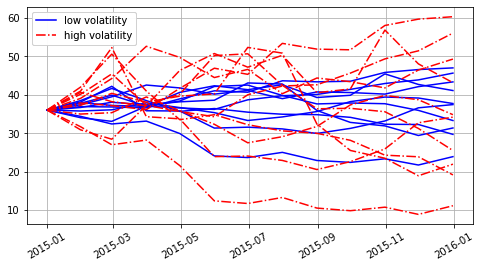

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 4))
p1 = plt.plot(gbm.time_grid, paths_1[:, :10], 'b')
p2 = plt.plot(gbm.time_grid, paths_2[:, :10], 'r-.')
plt.grid(True)
l1 = plt.legend([p1[0], p2[0]], ['low volatility', 'high volatility'], loc=2)
plt.gca().add_artist(l1)
plt.xticks(rotation=30)